In [1]:
# Import required libraries
import os
import sys
import torch
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Add project root to path for imports
project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import project modules from new structure
from configs.config import Config
from src.utils.data_utils import (
    load_labels_from_csv, 
    SignLanguageDataset, 
    create_data_loaders,
    flip_keypoints,
    transform_keypoints
)
from src.models.model_utils import (
    create_adjacency_matrix,
    create_model
)
from src.models.model import (
    HGC_LSTM,
    AttentionPooling
)
from src.training.train_utils import (
    train_model
)
from src.utils.visualization_utils import (
    visualize_training_process,
    analyze_model_performance
)

print("✅ All modules imported successfully!")
print(f"📦 Project structure reorganized with modular imports")
print(f"🐍 Python: {sys.version}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🔧 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔧 CUDA Device: {torch.cuda.get_device_name(0)}")
print()

# Initialize configuration
config = Config()
print("🔧 Configuration loaded from configs/config.py")
print(f"📊 Data from: {config.data.input_kp_path}")
print(f"💾 Models save to: {config.model.checkpoint_dir}")
print(f"📈 Plots save to: {config.output.plots_dir}")

✅ All modules imported successfully!
📦 Project structure reorganized with modular imports
🐍 Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
🔥 PyTorch: 2.7.0+cu126
🔧 CUDA Available: True
🔧 CUDA Device: NVIDIA GeForce RTX 3070 Ti

🔧 Configuration loaded from configs/config.py
📊 Data from: data_original/Keypoints
💾 Models save to: outputs/models
📈 Plots save to: outputs/plots


In [2]:
# Import data utilities
from src.utils.data_utils import load_labels_from_csv

# Load labels
video_to_label_mapping, label_to_idx, unique_labels, id_to_label_mapping = load_labels_from_csv(None, config)
num_classes = len(unique_labels)

 15 classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
 300 videos


In [3]:
# Import data augmentation and dataset utilities
from src.utils.data_utils import flip_keypoints, transform_keypoints, SignLanguageDataset

In [4]:
# Create datasets with stratified split and augmentation
print("[INFO] Creating datasets...")
keypoints_dir = config.data.keypoints_output_dir

# Set random seed for reproducible splits
np.random.seed(42)

# Get parameters from config
use_strategy = config.data.use_strategy


# Training uses augmentation, validation does not (for fair evaluation)
train_augmentations = getattr(config.data, 'augmentations', [])
val_augmentations = [] 

print(f"Configuration:")
print(f"   Split strategy: {'Stratified' if use_strategy else 'Random'}")
print(f"   Train augmentations: {train_augmentations if train_augmentations else 'None'}")
print(f"   Val augmentations: {val_augmentations if val_augmentations else 'None (for fair evaluation)'}")
if 'translation' in train_augmentations:
    print(f"   Translation range: ±{config.data.translation_range}")
if 'scaling' in train_augmentations:
    print(f"   Scale range: ±{config.data.scale_range}")

train_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, config,
    split_type='train', 
    augmentations=train_augmentations,
    use_strategy=use_strategy
)

val_dataset = SignLanguageDataset(
    keypoints_dir, video_to_label_mapping, label_to_idx, config,
    split_type='val', 
    augmentations=val_augmentations,
    use_strategy=use_strategy
)

print(f"\n[INFO] Dataset summary:")
print(f"  Total classes: {len(unique_labels)}")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
print(f"  Strategy: {'Stratified' if use_strategy else 'Random'} split")

[INFO] Creating datasets...
Configuration:
   Split strategy: Stratified
   Train augmentations: ['flip', 'translation', 'scaling']
   Val augmentations: None (for fair evaluation)
   Translation range: ±0.1
   Scale range: ±0.1
 Using stratified split strategy
 TRAIN dataset: 240 original files
 Augmentation enabled: 1920 total samples (x8)
  - Augmentations: ['flip', 'translation', 'scaling']
  - Total combinations: 8
  - Combinations: ['original', 'flip', 'translation', 'scaling', 'flip+translation', 'flip+scaling', 'translation+scaling', 'flip+translation+scaling']
 TRAIN class distribution:
  Class 1: 16 samples
  Class 2: 16 samples
  Class 3: 16 samples
  Class 4: 16 samples
  Class 5: 16 samples
  Class 6: 16 samples
  Class 7: 16 samples
  Class 8: 16 samples
  Class 9: 16 samples
  Class 10: 16 samples
  Class 11: 16 samples
  Class 12: 16 samples
  Class 13: 16 samples
  Class 14: 16 samples
  Class 15: 16 samples
 ✓ Balanced: 16 samples per class
 Using stratified split str

In [5]:
# Import data loader utility
from src.utils.data_utils import create_data_loaders

# Create data loaders
print("\n[INFO] Creating data loaders...")
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, config)


[INFO] Creating data loaders...
 Train batches: 240
 Valid batches: 8
 Batch size: 8
 Data Augmentation (flip + translation + scaling): 240 original → 1920 total samples
 Augmentation combinations: ['original', 'flip', 'translation', 'scaling', 'flip+translation', 'flip+scaling', 'translation+scaling', 'flip+translation+scaling']
 Sample keypoints shape: torch.Size([8, 60, 75, 2])
 Sample labels shape: torch.Size([8])


In [6]:
# Import model utilities
from src.models.model_utils import create_adjacency_matrix

A = create_adjacency_matrix(config)
print(f"[INFO] Adjacency matrix shape: {A.shape}")
print(f"[INFO] Number of vertices: {config.hgc_lstm.num_vertices}")

[INFO] Adjacency matrix shape: torch.Size([75, 75])
[INFO] Number of vertices: 75


In [7]:
# Import model classes and utilities
from src.models.model_utils import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(config, A, num_classes, device)

Model created with 285584 parameters
Model configuration:
  - GCN layers: 2
  - GCN hidden dim: 128
  - LSTM hidden dim: 128
  - LSTM layers: 1
  - Bidirectional: True
  - Dropout: 0.5
  - Pooling type: attention
  - Sequence length: 60
  - Number of vertices: 75
  - Using Attention Pooling with dropout: 0.5
  - Attention weights can be visualized after forward pass


In [8]:
# Import training utilities
from src.training.train_utils import train_model

In [9]:
print("[INFO] Starting training...")
print(f"[INFO] Training configuration:")
print(f"  - Epochs: {config.training.num_epochs}")
print(f"  - Batch size: {config.training.batch_size}")
print(f"  - Learning rate: {config.training.learning_rate}")
print(f"  - Optimizer: {config.training.optimizer}")
print(f"  - Scheduler: {config.training.scheduler}")
print(f"  - Early stopping patience: {config.training.early_stopping_patience}")
history = train_model(model, train_loader, val_loader, config, device)

[INFO] Starting training...
[INFO] Training configuration:
  - Epochs: 300
  - Batch size: 8
  - Learning rate: 0.001
  - Optimizer: adam
  - Scheduler: step
  - Early stopping patience: 50
Epoch 001/300 | Train Loss: 2.7241 Acc: 06.30% | Val Loss: 2.7142 Acc: 08.33% | LR: 0.00100000
Epoch 002/300 | Train Loss: 2.7106 Acc: 06.82% | Val Loss: 2.7055 Acc: 06.67% | LR: 0.00100000
Epoch 003/300 | Train Loss: 2.5688 Acc: 11.88% | Val Loss: 2.3756 Acc: 16.67% | LR: 0.00100000
Epoch 004/300 | Train Loss: 2.3130 Acc: 18.07% | Val Loss: 2.1181 Acc: 21.67% | LR: 0.00100000
Epoch 005/300 | Train Loss: 2.2060 Acc: 21.09% | Val Loss: 2.0454 Acc: 28.33% | LR: 0.00100000
Epoch 006/300 | Train Loss: 2.1306 Acc: 22.50% | Val Loss: 2.0626 Acc: 26.67% | LR: 0.00100000
Epoch 007/300 | Train Loss: 2.0113 Acc: 27.34% | Val Loss: 1.9353 Acc: 30.00% | LR: 0.00100000
Epoch 008/300 | Train Loss: 1.9311 Acc: 30.31% | Val Loss: 1.7216 Acc: 33.33% | LR: 0.00100000
Epoch 009/300 | Train Loss: 1.8880 Acc: 31.25% | V

# Training Process Visualization

This section provides essential visualization of the training process including:
- **Loss curves**: Training and validation loss over epochs
- **Accuracy curves**: Training and validation accuracy over epochs  
- **Confusion matrix**: Model performance analysis on validation set

[INFO] Generating training process visualization...
Training curves saved to: training_plots/training_curves.png


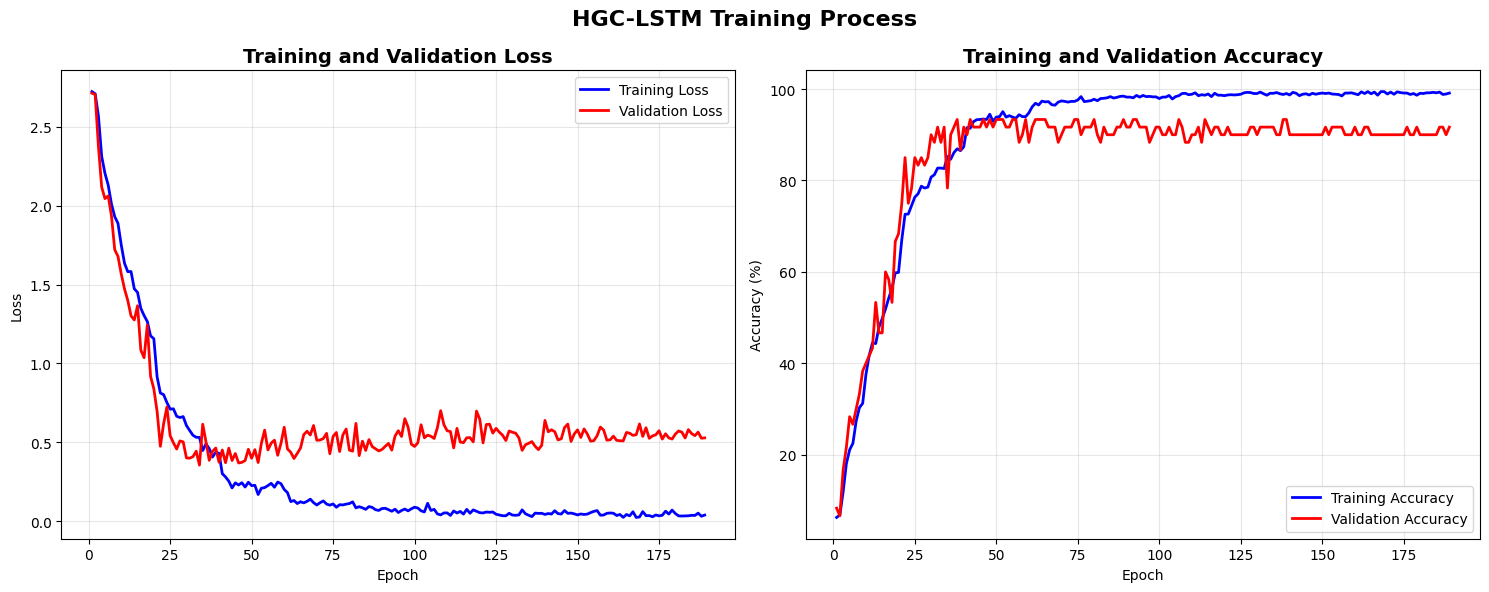


📊 TRAINING SUMMARY:
   Best Validation Accuracy: 93.33% (Epoch 38)
   Final Training Accuracy: 99.11%


In [10]:
# Import visualization utilities
from src.utils.visualization_utils import visualize_training_process

# Visualize training process
print("[INFO] Generating training process visualization...")
training_fig = visualize_training_process(history, config, save_plots=True)

[INFO] Analyzing model performance...
 Analyzing model performance on validation set...
Confusion matrix saved to: training_plots/confusion_matrix.png


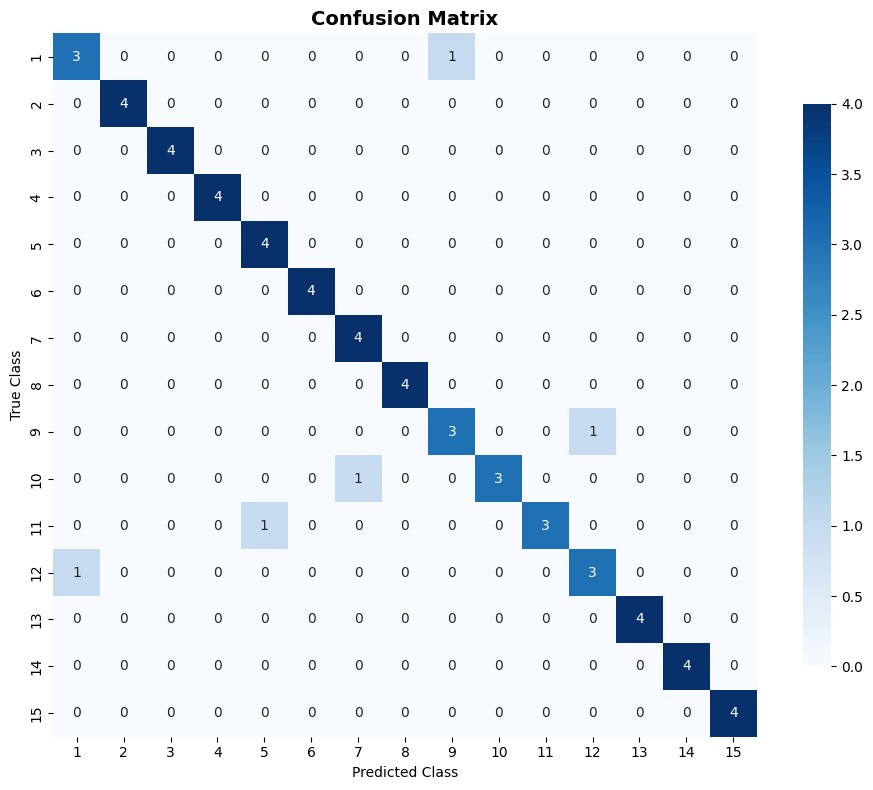


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class_1       0.75      0.75      0.75         4
     Class_2       1.00      1.00      1.00         4
     Class_3       1.00      1.00      1.00         4
     Class_4       1.00      1.00      1.00         4
     Class_5       0.80      1.00      0.89         4
     Class_6       1.00      1.00      1.00         4
     Class_7       0.80      1.00      0.89         4
     Class_8       1.00      1.00      1.00         4
     Class_9       0.75      0.75      0.75         4
    Class_10       1.00      0.75      0.86         4
    Class_11       1.00      0.75      0.86         4
    Class_12       0.75      0.75      0.75         4
    Class_13       1.00      1.00      1.00         4
    Class_14       1.00      1.00      1.00         4
    Class_15       1.00      1.00      1.00         4

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
wei

In [11]:
# Import model performance analysis
from src.utils.visualization_utils import analyze_model_performance

# Analyze model performance
print("[INFO] Analyzing model performance...")
performance_results = analyze_model_performance(model, val_loader, device, config, unique_labels, id_to_label_mapping)